  # Autoencoder - SNNL Dev

# Setup

In [34]:
# %pwd
# %cd ~/WSL-shared/Cellpainting/pt-snnl/
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import os
import sys
import csv
import json
import time
import types, copy, pprint
import logging 
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
# import shutil
# import getpass
import yaml

import hydra 
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf


from matplotlib import pyplot as plt
from typing import Dict, List, Tuple
from scipy.sparse import csr_matrix
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torchinfo import summary
import wandb

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
print(torch.__version__)

pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-MAIN-SNNL.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

['../..', './src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/cytominer_eval-0.1-py3.11.egg']
2.2.1+cu118


In [36]:
from KevinsRoutines.utils.utils_wandb  import  init_wandb, wandb_log_metrics,wandb_watch
from KevinsRoutines.utils.utils_general  import  list_namespace, print_heading, print_underline 
from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from snnl.utils import load_model, save_model, import_results, export_results, save_checkpoint, load_checkpoint 
from snnl.utils import plot_model_parms, plot_train_history, plot_classification_metrics, plot_regression_metrics
from snnl.utils import display_epoch_metrics, display_cellpainting_batch, display_model_parameters
from snnl.utils import CellpaintingDataset, InfiniteDataLoader, custom_collate_fn
from snnl.utils import display_model_summary, define_autoencoder_model
from snnl.utils import save_checkpoint_v2, load_checkpoint_v2, save_checkpoint_v3

In [37]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__) 
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}")
# logger.info(f" Search path      : {sys.path}")

2024-07-03 23:19:33,855 - __main__ - INFO: -  Excution started : 2024_07_03_23:19:33 
2024-07-03 23:19:33,856 - __main__ - INFO: -  Pytorch version  : 2.2.1+cu118


### Hydra

In [38]:
# hydra.core.global_hydra.GlobalHydra.instance().clear()

# abs_config_dir=os.path.abspath("hyperparameters")
# abs_config_dir
# # GlobalHydra.instance().clear() 
# initialize_config_dir(version_base=None, config_dir=abs_config_dir)
# # initialize(version_base=None, config_path="hyperparameters")

# cfg=compose(config_name="AE_Base.yaml")
# type(cfg)
# print(cfg)
# cfgyaml = OmegaConf.to_yaml(cfg)
# type(cfgyaml)
# print(cfgyaml)

### main(args)

In [39]:
WANDB_ACTIVE  = False
LATENT_DIM    = 150
HIDDEN_1      = 512
# HIDDEN_2    = '_256'
HIDDEN_2      = ''
DATE          = '2024062-01'
LOAD_EPOCH    = 200
EPOCHS        = 10
COMPOUNDS_PER_BATCH = 200
LEARNING_RATE = 1.00e-04
TEMP          = 0.05
TEMP_LR       = 1.00e-05
CHECKPT       = f"AE_snnl_dcpb{COMPOUNDS_PER_BATCH}_{LATENT_DIM}Ltnt_{HIDDEN_1}{HIDDEN_2}_{DATE}_LAST_ep_{LOAD_EPOCH:03d}.pt"
CHECKPT

'AE_snnl_dcpb200_150Ltnt_512_2024062-01_LAST_ep_200.pt'

In [40]:
# if __name__ == "__main__":
cli_args =   f" --runmode            snnl " \
             f" --configuration      hyperparameters/ae_sn_150_512_cpb.yaml" \
             f" --lr                 {LEARNING_RATE} "\
             f" --prim_opt           --temp_opt " \
             f" --temp               {TEMP} "\
             f" --temp_lr            {TEMP_LR}"\
             f" --epochs             {EPOCHS} " \
             f" --cpb                {COMPOUNDS_PER_BATCH}" \
	         f" --seed   4321    --gpu_id  0  "\
             f" "
            # f" --wandb"\
             # f" --ckpt               AE_snnl_dcpb200_{LATENT_DIM}Ltnt_{HIDDEN_1}{HIDDEN_2}_{DATE}_LAST_ep_{LOAD_EPOCH:03d}.pt " \
            #  f" --ckpt               AE_baseline_{DATE}_snglOpt-{LATENT_DIM}Ltnt{HIDDEN_1}{HIDDEN_2}_ep_{LOAD_EPOCH}.pt " \
             # f" --configuration      hyperparameters/ae_sn_{LATENT_DIM:03d}{HIDDEN_1}{HIDDEN_2}_cpb.yaml" \
             # f" --run_id              " \
             # f" --exp_title           snglOpt-050Ltnt_512_sig "
             # f" --runmode            snnl" \
cli_args = parse_args(cli_args.split())
cli_args

args = load_configuration(cli_args)
args.ckpt


Namespace(configuration='hyperparameters/ae_sn_150_512_cpb.yaml', ckpt=None, cpb=200, exp_title=None, epochs=10, gpu_id=0, learning_rate=0.0001, exp_id=None, runmode='snnl', random_seed=4321, use_prim_optimizer=True, use_temp_optimizer=True, use_annealing=False, use_single_loss=False, temperature=0.05, temperatureLR=1e-05, wandb=False)

2024-07-03 23:19:37,144 - snnl.utils.utils - INFO: -  command line param configuration             : [hyperparameters/ae_sn_150_512_cpb.yaml]
2024-07-03 23:19:37,145 - snnl.utils.utils - INFO: -  command line param ckpt                      : [None]
2024-07-03 23:19:37,146 - snnl.utils.utils - INFO: -  command line param cpb                       : [200]
2024-07-03 23:19:37,147 - snnl.utils.utils - INFO: -  command line param exp_title                 : [None]
2024-07-03 23:19:37,147 - snnl.utils.utils - INFO: -  command line param epochs                    : [10]
2024-07-03 23:19:37,148 - snnl.utils.utils - INFO: -  command line param gpu_id                    : [0]
2024-07-03 23:19:37,148 - snnl.utils.utils - INFO: -  command line param learning_rate             : [0.0001]
2024-07-03 23:19:37,149 - snnl.utils.utils - INFO: -  command line param exp_id                    : [None]
2024-07-03 23:19:37,150 - snnl.utils.utils - INFO: -  command line param runmode                   : [snnl

In [41]:
args

namespace(project_name='CellPainting_Profiles',
          exp_id=None,
          exp_name_pfx=None,
          exp_name=None,
          exp_date=None,
          exp_title='dcpb200_150Ltnt_512',
          exp_description='AE snnl - DualOpt, 150 dim latent, 512 Midlayer, 200 cpb',
          exp_folder=None,
          folder_sfx=None,
          random_seed=4321,
          units=[['linear', 1471, 1024],
                 ['relu', 0, 0],
                 ['linear', 1024, 512],
                 ['relu', 0, 0],
                 ['linear', 512, 150],
                 ['linear', 150, 512],
                 ['relu', 0, 0],
                 ['linear', 512, 1024],
                 ['relu', 0, 0],
                 ['linear', 1024, 1471]],
          input_shape=1471,
          code_units=150,
          embedding_layer=4,
          show_every=1,
          save_every=25,
          learning_rate=0.0001,
          loss_factor=1.0,
          adam_weight_decay=0,
          snnl_factor=0.5,
          tempera

In [9]:
set_global_seed(args.random_seed)
if args.ckpt is not None:
    if os.path.exists(os.path.join('ckpts', args.ckpt)):
        logger.info(f" Checkpoint {args.ckpt} found")
        logger.info(f" Resuming training using checkpoint: {args.ckpt}")
    else:
        logger.error(f" *** Checkpoint {args.ckpt} not found *** \n")
        raise ValueError(f"\n *** Checkpoint DOESNT EXIST *** \n")

if args.gpu_id is not None:
    _ = get_device()
    # print(f"Current device is : {current_device}")    
    current_device = set_device(args.gpu_id)
    current_device = get_device()


2024-07-03 18:17:55,160 - snnl.utils.utils - INFO: -  Current CUDA Device is:  cuda:0 - Quadro GV100
2024-07-03 18:17:55,162 - snnl.utils.utils - INFO: -  Switched to: Quadro GV100 - 0
2024-07-03 18:17:55,163 - snnl.utils.utils - INFO: -  Current CUDA Device is:  cuda:0 - Quadro GV100


## Define dataset and dataloaders

In [10]:
#### Load CellPainting Dataset
logging.info(f" load {args.dataset}")
train_dataset = CellpaintingDataset(type='train',    **args.cellpainting_args)
train_loader = InfiniteDataLoader(dataset=train_dataset, batch_size = args.batch_size, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)
val_dataset = CellpaintingDataset(type='val',    **args.cellpainting_args)
val_loader = InfiniteDataLoader(dataset=val_dataset, batch_size = args.batch_size, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)

2024-07-03 18:17:56,558 - root - INFO: -  load cellpainting
2024-07-03 18:17:56,559 - snnl.utils.dataloader - INFO: -  Building CellPantingDataset for train
2024-07-03 18:17:56,560 - snnl.utils.dataloader - INFO: -  filename:  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
2024-07-03 18:17:56,561 - snnl.utils.dataloader - INFO: -  type    :  train
2024-07-03 18:17:56,561 - snnl.utils.dataloader - INFO: -  start   :  0
2024-07-03 18:17:56,562 - snnl.utils.dataloader - INFO: -  end     :  240000
2024-07-03 18:17:56,562 - snnl.utils.dataloader - INFO: -  numrows :  240000
2024-07-03 18:17:56,563 - snnl.utils.dataloader - INFO: -  Each mini-batch contains 200.0 compounds with 3 samples per compound : total 600 rows
2024-07-03 18:17:56,564 - snnl.utils.dataloader - INFO: -  Number of 600 row full size batches per epoch: 400
2024-07-03 18:17:56,564 - snnl.utils.dataloader - INFO: -  Rows covered by 400 full size batches (

## WandB Setup

In [11]:
# args.exp_id   = None
# args.exp_name = 'AE_'+datetime.now().strftime('%m%d_%H%M')
# args.exp_date = datetime.now().strftime('%Y%m%d')

## --- for restarts
# args.exp_id   = '0g8w13h6'
# args.exp_name = 'AE_0516_1104'
# args.exp_date = '20240516'
##-----------------
logger.info(f" args.wandb       : {args.wandb}")
logger.info(f" Project Name     : {args.project_name}")
logger.info(f" Experiment Id    : {args.exp_id}")
logger.info(f" Experiment Name  : {args.exp_name}")
logger.info(f" Experiment Date  : {args.exp_date}")
logger.info(f" Experiment Title : {args.exp_title}")
logger.info(f" Experiment Notes : {args.exp_description}")
EXP_DATE = datetime.now().strftime('%y%m%d_%H%M')
args.exp_name = f"AE_{EXP_DATE}"
args.exp_date = EXP_DATE
logger.info(f" Experiment Name  : {args.exp_name}")
logger.info(f" Experiment Date  : {args.exp_date}")

2024-07-03 18:18:07,781 - __main__ - INFO: -  args.wandb       : False
2024-07-03 18:18:07,782 - __main__ - INFO: -  Project Name     : CellPainting_Profiles
2024-07-03 18:18:07,783 - __main__ - INFO: -  Experiment Id    : None
2024-07-03 18:18:07,784 - __main__ - INFO: -  Experiment Name  : None
2024-07-03 18:18:07,785 - __main__ - INFO: -  Experiment Date  : None
2024-07-03 18:18:07,785 - __main__ - INFO: -  Experiment Title : dcpb200_150Ltnt_512
2024-07-03 18:18:07,786 - __main__ - INFO: -  Experiment Notes : AE snnl - DualOpt, 150 dim latent, 512 Midlayer, 200 cpb
2024-07-03 18:18:07,787 - __main__ - INFO: -  Experiment Name  : AE_240703_1818
2024-07-03 18:18:07,787 - __main__ - INFO: -  Experiment Date  : 240703_1818


In [12]:
WANDB_ACTIVE = args.wandb

EXP_DATE = datetime.now().strftime('%y%m%d_%H%M')
args.exp_name = f"AE_{EXP_DATE}"
args.exp_date = EXP_DATE

if WANDB_ACTIVE:
    if args.exp_id is not None:
        print("Resume")
        resume_wandb = True
    else:
        print("Initialize")
        resume_wandb = False
        args.exp_name = f"AE_{EXP_DATE}"
    
    wandb_run = init_wandb(args)
    
    args.exp_id = wandb_run.id
    
    logger.info(f" WandB tracking started ")
    logger.info(f" Project  : {args.project_name}")    
    logger.info(f" Run id   :  {args.exp_id}   / {wandb_run.id}")
    logger.info(f" Name     :  {args.exp_name} / {wandb_run.name} ")
    logger.info(f" Title    :  {args.exp_title}")    
    logger.info(f" Date     :  {args.exp_date}  ")
    logger.info(f" Notes    :  {args.exp_description} / {wandb_run.notes} ")
else: 
    logger.info(f" *** W&&B Logging is INACTIVE *** ")
    args.exp_name = 'AE_'+datetime.now().strftime('%y%m%d_%H%M')
    args.exp_date = datetime.now().strftime('%y%m%d_%H%M')    

logger.info(f" Experiment run id:  {args.exp_id}")
logger.info(f" Experiment Name  :  {args.exp_name} ")
logger.info(f" Experiment Date  :  {args.exp_date} ")
logger.info(f" Experiment Title :  {args.exp_title} ")
logger.info(f" Experiment Notes :  {args.exp_description}")

2024-07-03 18:18:09,189 - __main__ - INFO: -  *** W&&B Logging is INACTIVE *** 
2024-07-03 18:18:09,190 - __main__ - INFO: -  Experiment run id:  None
2024-07-03 18:18:09,191 - __main__ - INFO: -  Experiment Name  :  AE_240703_1818 
2024-07-03 18:18:09,192 - __main__ - INFO: -  Experiment Date  :  240703_1818 
2024-07-03 18:18:09,193 - __main__ - INFO: -  Experiment Title :  dcpb200_150Ltnt_512 
2024-07-03 18:18:09,193 - __main__ - INFO: -  Experiment Notes :  AE snnl - DualOpt, 150 dim latent, 512 Midlayer, 200 cpb


# Define autoencoder model

## Override arguments

In [13]:
# args.temperature   = 0.8
# args.loss_factor   = 2.0        ## 2.0e+00
# args.snnl_factor   = 0.5       ## 1.0e+00
# args.learning_rate = 1.0e-03    ## 0.001
# args.temperatureLR = 1.0e-04    ## 1e-4
# print(f"   Latent dim        {args.code_units}  \t\t  loss_factor       {args.loss_factor}  \t\t   snnl_factor       {args.snnl_factor}")
# print(f"   temperature       {args.temperature} \t\t  learning_rate     {args.learning_rate} \t\t   temperatureLR:    {args.temperatureLR}")

In [14]:
# list_namespace(args)

## Define Model

In [15]:
model = define_autoencoder_model(args,device = current_device)

if WANDB_ACTIVE:
    wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = True)

2024-07-03 18:18:13,896 - snnl.utils.utils - INFO: - Defining model in SNNL mode 
2024-07-03 18:18:13,922 - snnl.models.autoencoder - INFO: -     layer pair:    0  type:linear           input:   1471  output:   1024    weights: [1024, 1471]   
2024-07-03 18:18:13,945 - snnl.models.autoencoder - INFO: -     layer pair:    1  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-07-03 18:18:13,946 - snnl.models.autoencoder - INFO: -     layer pair:    2  type:linear           input:   1024  output:    512    weights: [512, 1024]   
2024-07-03 18:18:13,953 - snnl.models.autoencoder - INFO: -     layer pair:    3  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-07-03 18:18:13,954 - snnl.models.autoencoder - INFO: -     layer pair:    4  type:linear           input:    512  output:    150    weights: [150, 512]   
2024-07-03 18:18:13,956 - snnl.models.autoencoder - INFO: -     layer pair:    5  type:linear           input:    150  outp

 EMBEDDING LAYER: 4
    Model_init()_    -- AE - support for unsupervised in latent_code mode is True

------------------------------------------------------------
 Build SNNLoss from AE_snnloss
------------------------------------------------------------
    SNNLoss _init()_    -- mode: latent_code was found in SNNLoss._supported_modes --   is unsupervised: True
    SNNLoss _init()_    -- unsupervised :     True
    SNNLoss _init()_    -- use_annealing :    False
    SNNLoss _init()_    -- sample_size :      3
    SNNLoss _init()_    -- temperature :      Parameter containing:
tensor([0.0500], requires_grad=True)
[Parameter containing:
tensor([[-0.0161, -0.0513, -0.0007,  ...,  0.0065, -0.0197,  0.0040],
        [-0.0360,  0.0660,  0.0020,  ...,  0.0216, -0.0110, -0.0195],
        [ 0.0159,  0.0130,  0.0351,  ..., -0.0203,  0.0426,  0.0003],
        ...,
        [ 0.0400,  0.0204, -0.0482,  ..., -0.0421, -0.0220,  0.0686],
        [-0.0085, -0.0265, -0.0047,  ...,  0.0023, -0.0226,  0

# Load model checkpoint 

In [16]:
if args.ckpt is not None:
    model.resume_training = True
    model , last_epoch = load_checkpoint_v2(model, args.ckpt, verbose = True )  
    model.train()
    model.device = current_device
    model = model.cuda(device=current_device)
    logging.info(f" Loaded Model device {model.device} -  Last completed epoch : {last_epoch}")
    model.starting_epoch = last_epoch
    model.ending_epoch = last_epoch + args.epochs
    logging.info(f" RESUME TRAINING - Run {args.epochs} epochs: epoch {model.starting_epoch+1} to {model.ending_epoch} ")

    if 'gen' not in model.training_history:
        print(f" Define self.training_history['gen'] ")
        model.training_history['gen'] = {'trn_best_metric' : 0, 'trn_best_metric_ep' : 0, 'trn_best_loss': np.inf, 'trn_best_loss_ep' : 0 ,
                                        'val_best_metric' : 0, 'val_best_metric_ep' : 0, 'val_best_loss': np.inf, 'val_best_loss_ep' : 0 }        
    
        for key in ['trn', 'val']:
            tmp = np.argmin(model.training_history[key][f'{key}_ttl_loss'])
            model.training_history['gen'][f'{key}_best_loss_ep'] = tmp
            model.training_history['gen'][f'{key}_best_loss']    = model.training_history[key][f'{key}_ttl_loss'][tmp]
            
            tmp1 = np.argmax(model.training_history[key][f'{key}_R2_score'])
            model.training_history['gen'][f'{key}_best_metric_ep'] = tmp1
            model.training_history['gen'][f'{key}_best_metric'] = model.training_history[key][f'{key}_R2_score'][tmp1]
    
else:
    model.resume_training = False
    model.starting_epoch = 0
    model.ending_epoch = args.epochs
    logging.info(f" INITIALIZE TRAINING - Run {args.epochs} epochs: epoch {model.starting_epoch+1} to {model.ending_epoch} ")

model.best_metric = model.training_history['gen'][f'val_best_metric']  
model.best_epoch  = model.training_history['gen'][f'val_best_metric_ep']  

2024-07-03 18:18:15,145 - root - INFO: -  INITIALIZE TRAINING - Run 10 epochs: epoch 1 to 10 


In [17]:
display_model_parameters(model)


 Model device           : cuda:0
 Model embedding_layer  : 4
 loss_factor            : 1.0
 monitor_grads_layer    : None
 Use Single Loss        : False
 Use Prim Optimizer     : True
 Use Prim Scheduler     : True
 Main Optimizer Params  : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
 Scheduler              : <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f23bf6aae10> 
    factor: 0.5  
    min_lrs: [0]  
    patience: 50  
    verbose: False  
    cooldown: 10  
    cooldown_counter: 0  
    mode: min  
    threshold: 1e-06  
    threshold_mode: rel  
    best: inf  
    num_bad_epochs: 0  
    mode_worse: inf  
    eps: 1e-08  
    last_epoch: 0  

 Use snnl               : True
 SNNL factor            : 0.5
 SNNL temperature       : Parameter containing:
tensor([0.0500], device='cuda:0', requires_

# Autoencoder `fit(data_loader = train_loader, epochs = epochs)` 

In [18]:
# print(f" loss_factor         : {model.loss_factor} \t\t snnl_factor   : {model.snnl_factor} \t\t model.temperature   : {model.temperature}")
# print(f" Learning rate : {model.optimizer.param_groups[0]['lr']}     model.TemperatureLR : {model.temperatureLR}") 
# model.starting_epoch, model.ending_epoch = 0, 2
# model.starting_epoch, model.ending_epoch

print(f" {datetime.now().strftime('%Y%m%d_%H%M%S')}  epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")

if WANDB_ACTIVE:
    wandb.config.update(args)

 20240703_181818  epoch    1 of   10


In [33]:
print(f" {datetime.now().strftime('%Y%m%d_%H%M%S')}  epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")
header = True

for epoch in range(model.starting_epoch, model.ending_epoch):
    train_loss = model.epoch_train(train_loader, epoch, DEBUG_COUNT = 3)
    val_loss = model.epoch_validate(val_loader, epoch)
    
    display_epoch_metrics(model, epoch, model.ending_epoch, header)
    header = False
    model.scheduling_step(val_loss)
    
    if WANDB_ACTIVE:
        epoch_metrics = {x:y     for x,y in model.training_history['gen'].items()} | \
                        {x:y[-1] for x,y in model.training_history['val'].items()} | \
                        {x:y[-1] for x,y in model.training_history['trn'].items()} 
        wandb_log_metrics( data = epoch_metrics, step = epoch)
    
    if model.new_best:
        save_checkpoint_v3(epoch+1, model, args, update_best=True)        
    if (epoch + 1) % args.save_every == 0:
        save_checkpoint_v3(epoch+1, model, args)    
        
print(f"Last Epoch {epoch+1}")
save_checkpoint_v3(epoch+1, model, args, update_latest=True)       

 20240703_211535  epoch   51 of  100
  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
21:17:40 51 /100  |   1.4381     0.2459     1.1921 |   0.028163   1.0373e+00 |   0.6281    49           |   2.1978     0.2531     1.9447 |   0.6123    39             |  1.000e-04   1.000e-05 |


2024-07-03 21:19:52,444 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240703_1818_BEST.pt - epoch: 52


21:19:52 52 /100  |   1.3605     0.2462     1.1143 |   0.024650   2.5410e+00 |   0.6312    49           |   2.1924     0.2506     1.9418 |   0.6309    52             |  1.000e-04   1.000e-05 |
21:22:05 53 /100  |   1.3902     0.2471     1.1431 |   0.029231   1.2958e+00 |   0.6322    49           |   2.1754     0.2505     1.9249 |   0.6249    52             |  1.000e-04   1.000e-05 |
21:24:19 54 /100  |   1.3969     0.2470     1.1499 |   0.020678   2.1518e+00 |   0.6265    49           |   2.2037     0.2468     1.9569 |   0.6317    54             |  1.000e-04   1.000e-05 |


2024-07-03 21:24:20,157 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240703_1818_BEST.pt - epoch: 54


21:26:34 55 /100  |   1.6741     0.2614     1.4126 |   0.078648  -5.2147e-01 |   0.6006    49           |   2.9947     0.3133     2.6814 |   0.5159    54             |  1.000e-04   1.000e-05 |
21:28:47 56 /100  |   2.7654     0.2795     2.4860 |   0.045268   4.3930e-01 |   0.5780    49           |   2.7046     0.2670     2.4376 |   0.5954    54             |  1.000e-04   1.000e-05 |
21:31:00 57 /100  |   2.3431     0.2584     2.0848 |   0.026869  -4.1757e-02 |   0.6130    49           |   2.3964     0.2566     2.1398 |   0.5982    54             |  1.000e-04   1.000e-05 |
21:33:14 58 /100  |   1.9937     0.2495     1.7442 |   0.023386   5.0805e-01 |   0.6248    49           |   2.2441     0.2501     1.9940 |   0.6092    54             |  1.000e-04   1.000e-05 |
21:35:28 59 /100  |   1.7762     0.2434     1.5328 |   0.020740   4.8725e-01 |   0.6326    49           |   2.1784     0.2451     1.9333 |   0.6159    54             |  1.000e-04   1.000e-05 |
21:37:38 60 /100  |   1.6207     0.

2024-07-03 21:42:04,401 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240703_1818_BEST.pt - epoch: 62


21:44:15 63 /100  |   1.4017     0.2360     1.1656 |   0.025429   2.1812e+00 |   0.6436    63           |   2.1526     0.2417     1.9109 |   0.6456    63             |  1.000e-04   1.000e-05 |


2024-07-03 21:44:15,985 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240703_1818_BEST.pt - epoch: 63


21:46:28 64 /100  |   1.3832     0.2388     1.1444 |   0.029911   1.4820e+00 |   0.6406    63           |   2.1731     0.2485     1.9247 |   0.6348    63             |  1.000e-04   1.000e-05 |
21:48:34 65 /100  |   1.3686     0.2399     1.1287 |   0.026864   7.7098e-01 |   0.6394    63           |   2.1515     0.2427     1.9087 |   0.6290    63             |  1.000e-04   1.000e-05 |
21:50:45 66 /100  |   1.3152     0.2359     1.0794 |   0.023645   8.2317e-01 |   0.6461    66           |   2.1554     0.2386     1.9168 |   0.6221    63             |  1.000e-04   1.000e-05 |
21:52:52 67 /100  |   1.3670     0.2402     1.1268 |   0.032994  -7.0801e-01 |   0.6392    66           |   2.2136     0.2521     1.9615 |   0.6264    63             |  1.000e-04   1.000e-05 |
21:55:02 68 /100  |   1.3338     0.2397     1.0941 |   0.025929  -8.8950e-01 |   0.6401    66           |   2.2025     0.2422     1.9603 |   0.6362    63             |  1.000e-04   1.000e-05 |
21:57:10 69 /100  |   1.4215     0.

2024-07-03 22:03:37,721 - snnl.models.base - INFO: -  Temperature optimizer learning rate reduced to [5e-06]


22:03:37 72 /100  |   1.3091     0.2362     1.0730 |   0.028068   5.5576e-01 |   0.6442    66           |   2.1618     0.2417     1.9201 |   0.6311    63             |  1.000e-04   1.000e-05 |
22:05:46 73 /100  |   1.2979     0.2390     1.0589 |   0.028547  -3.5420e+00 |   0.6382    66           |   2.2091     0.2423     1.9668 |   0.6272    63             |  1.000e-04   5.000e-06 |
22:07:54 74 /100  |   1.2554     0.2361     1.0192 |   0.028879   2.3384e+00 |   0.6430    66           |   2.1561     0.2385     1.9175 |   0.6324    63             |  1.000e-04   5.000e-06 |


2024-07-03 22:10:05,997 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240703_1818_ep_075.pt - epoch: 75


22:10:05 75 /100  |   1.4068     0.2404     1.1664 |   0.020619  -1.2502e+00 |   0.6383    66           |   2.1990     0.2421     1.9569 |   0.6226    63             |  1.000e-04   5.000e-06 |
22:12:18 76 /100  |   1.3836     0.2378     1.1458 |   0.028600   1.4040e-01 |   0.6435    66           |   2.2083     0.2454     1.9629 |   0.6342    63             |  1.000e-04   5.000e-06 |
22:14:30 77 /100  |   1.3828     0.2365     1.1463 |   0.023089   1.4761e+00 |   0.6448    66           |   2.1687     0.2362     1.9325 |   0.6298    63             |  1.000e-04   5.000e-06 |
22:16:42 78 /100  |   1.3881     0.2397     1.1484 |   0.024407  -9.5641e-01 |   0.6312    66           |   2.1964     0.2418     1.9546 |   0.6161    63             |  1.000e-04   5.000e-06 |
22:18:49 79 /100  |   1.3425     0.2355     1.1070 |   0.025944  -1.5817e+00 |   0.6431    66           |   2.1789     0.2395     1.9394 |   0.6216    63             |  1.000e-04   5.000e-06 |
22:20:58 80 /100  |   1.3285     0.

2024-07-03 22:49:08,735 - snnl.utils.utils - INFO: -  Model exported to ckpts/AE_snnl_dcpb200_150Ltnt_512_240703_1818_BEST.pt - epoch: 93


batch 338 - layer 4
--- NAN Encountred  ----------------------------------------------------------------------------------------------------
93/338 : Temperature              : -0.007194641046226025  
93/338 : Pairwise distance matrix : torch.Size([600, 600])  Min: 0.0  argmin: 0   Max: 1.1185470819473267  argmax:  196145  Sum: 195699.5
93/338 : -(Distance matrix / Temp): torch.Size([600, 600])  Min: 0.0  argmin: 0   Max: 155.469482421875  argmax:  196145  Sum: 27200732.0
93/338 : exp((-Dist mat / Temp))  : torch.Size([600, 600])  Min: 1.0  argmin: 0   Max: inf  argmax:  9  Sum: inf
93/338 : Distance matrix exponent : torch.Size([600, 600])  Min: 0.0  argmin: 0   Max: inf  argmax:  196145  Sum: inf
93/338 : Pick Probability Matrix  : torch.Size([600, 600])  Min: nan  argmin: 9   Max: nan  argmax:  9  Sum: nan
93/338 : Summed pick_probability  :  torch.Size([600])  Min nan  argmin: 0  Max: nan  argmax:  0  Sum: nan
93/338 : mean(-log(summed_picked_probabilty)) -  nan
-------------------

ValueError:  Nan encountered....

In [ ]:
model.training_history.keys()
model.training_history['gen']
# epoch_metrics.keys()

### Close WandB Logging

In [ ]:
if WANDB_ACTIVE:
    wandb_run.finish()
    WANDB_ACTIVE = False

In [22]:
epoch, model.starting_epoch, model.ending_epoch

(9, 0, 10)

In [29]:
for epoch in range(model.ending_epoch):
    display_epoch_metrics(model, epoch)

  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
18:20:45  1 / 50  |   3.2818     0.8579     2.4240 |   0.054961   2.7755e-01 | -13.4074    49           |   2.7949     0.5691     2.2259 |  -4.5259    39             |  1.000e-04   1.000e-05 |
18:22:52  2 / 50  |   2.5728     0.4985     2.0743 |   0.044622   9.3485e-02 |  -3.4225    49           |   2.5011     0.4385     2.0626 |  -2.1521    39             |  1.000e-04   1.000e-05 |
18:24:58  3 / 50  |   2.3252     0.4178     1.9074 |   0.038977   1.1651e-01 |  -1.6427    49           |   2.3693     0.3909     1.9784 |  -1.1240    39             |  1.000e-04   1.000e-05 |
18:27:05  4 / 50  |   2.1669     0.

In [30]:
# model.starting_epoch = 59
# epochs = 100
# model.ending_epoch = 100
model.starting_epoch = model.ending_epoch
model.ending_epoch += 50
print(f" {datetime.now().strftime('%Y%m%d_%H%M%S')}  epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")

 20240703_211458  epoch   51 of  100


## Misc stuff

In [ ]:
def display_epoch_metrics(model, epoch = None, epochs = None, header = False):
    # key1, key2 = model.training_history.keys()
    key1 = 'trn' ##if key1 == 'trn' else ''
    key2 = 'val' ##if key1_p == 'trn' else ''
    
    history_len = len(model.training_history[key1][f'{key1}_ttl_loss'])
    epochs = history_len if epochs is None else epochs
    epoch  = 0 if epoch is None else epoch
    header = True if epoch == 0 else header
    
    idx = epoch
    if idx>=epochs:
        return
    if model.use_snnl:
        temp_hist = model.training_history[key1]['temp_hist'][idx]
        temp_grad_hist = model.training_history[key1]['temp_grad_hist'][idx]
        temp_LR = model.training_history[key1]["temp_lr"][idx] 
    else:
        temp_hist = 0
        temp_grad_hist = 0
        temp_LR = 0
        
    trn_LR = model.training_history[key1]["trn_lr"][idx] if model.use_prim_scheduler else 0.0
 
    if model.unsupervised:
        if header:
            print(f"  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |")
            print(f"------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|")
                 # "00:45:46 ep   1 / 10 |   9.909963    4.904229    5.005733 |  14.996347   -2.6287e-10 |                          |   9.833426    4.827625    5.005800 |                          |"
        print(f"{model.training_history[key2][f'{key2}_time'][idx]} {epoch + 1:^3d}/{epochs:^4d} |"
              f" {model.training_history[key1][f'{key1}_ttl_loss'][idx]:8.4f}   {   model.training_history[key1][f'{key1}_prim_loss'][idx]:8.4f}   {   model.training_history[key1][f'{key1}_snn_loss'][idx]:8.4f} |"
              f" {temp_hist:10.6f}  {temp_grad_hist:11.4e} |"
              f" {model.training_history[key1][f'{key1}_R2_score'][idx]:8.4f}   {model.training_history['gen'].get('trn_best_metric_ep',0)+1:3d}           |"
              f" {model.training_history[key2][f'{key2}_ttl_loss'][idx]:8.4f}   {   model.training_history[key2][f'{key2}_prim_loss'][idx]:8.4f}   {   model.training_history[key2][f'{key2}_snn_loss'][idx]:8.4f} |"
              f" {model.training_history[key2][f'{key2}_R2_score'][idx]:8.4f}   {model.training_history['gen'].get('val_best_metric_ep',0)+1:3d}             |"
              f" {trn_LR :10.3e}  {temp_LR :10.3e} |")
        
    else:
        pass

In [31]:
# save_checkpoint_v3(1, model, args, update_latest=True)  

In [ ]:
# model.temperature.data
# model.snnl_criterion.temperature
display_epoch_metrics(model, epoch, model.ending_epoch, header = True)

In [ ]:
# model.starting_epoch, model.ending_epoch = 0, 2
# epoch = 1
# model.temperature = torch.abs(model.temperature)
# model.temperature = torch.nn.Parameter(torch.clip(model.temperature, 0.001, None))
# model.snnl_criterion.temperature= torch.nn.Parameter(torch.clip(model.snnl_criterion.temperature, 0.001, None))

In [ ]:
# model.temperature.data
# model.snnl_criterion.temperature

In [ ]:
# model.starting_epoch, model.ending_epoch = 0, 2
# epoch = 1
# model.temperature = torch.abs(model.temperature)
# model.temperature = torch.nn.Parameter(torch.clip(model.temperature, 0.001, None))
# model.snnl_criterion.temperature= torch.nn.Parameter(torch.clip(model.snnl_criterion.temperature, 0.001, None))

In [ ]:
model.state_dict().keys()
# for k in ['temperature', 'snnl_criterion.temperature'
for k in ['temperature', 'snnl_criterion.temperature','layers.0.weight', 'layers.0.bias','layers.2.weight','layers.4.weight','layers.4.bias','layers.5.weight','layers.5.bias','layers.7.weight','layers.9.weight','layers.9.bias',]:
    if model.state_dict()[k].ndim > 1:
        print(f" {k+' - '+str(model.state_dict()[k].shape):45s} - {model.state_dict()[k][:3,:3].reshape((-1)).data}")
    else:
        print(f" {k+' - '+str(model.state_dict()[k].shape):45s} - {model.state_dict()[k][:9].data}")


# Plot losses, weights, biases and gradients

In [ ]:
# if 0:
#     model_attributes = model.__dict__
#     model.training_history['train'].keys()
#     for key, value in model.training_history['train'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")
#     print()
#     for key, value in model.training_history['val'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")        

In [ ]:
# tmp = np.array(model.training_history['train']['temp_grads'])
# for st in range(0,len(tmp), 1000):
#     end = st + 1000
#     print(f" {st:5d} - {end:5d}  min: {tmp[st:end].min():9e}   max: {tmp[st:end].max():9e}    avg: {tmp[st:end].mean():9e}   std: {tmp[st:end].std():9e}")

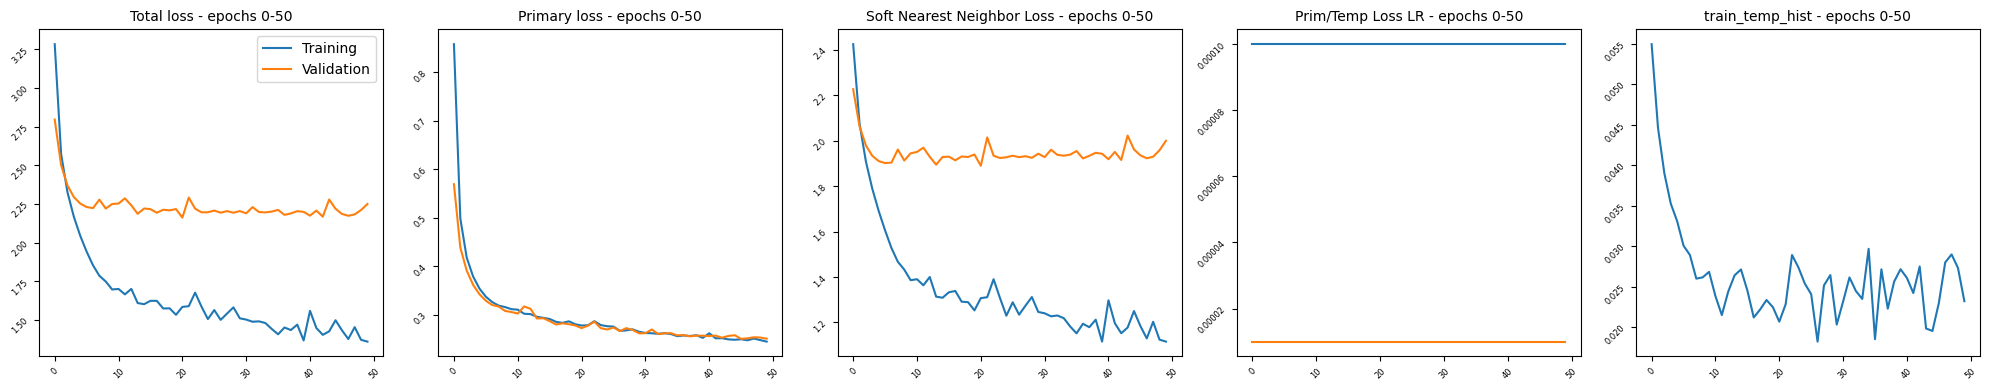

In [28]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 100, n_bins = 25)

In [ ]:
plot_train_history(model, start= 10, n_bins = 25)

In [ ]:
plot_train_history(model, start= 10, n_bins = 25)

In [ ]:
plot_model_parms(model, epochs= epochs, n_bins = 15)

In [ ]:
from snnl.utils import plot_regression_metrics
# plot_train_metrics(model, n_bins = 25)
plot_regression_metrics(model, n_bins = 25)

# Save model results and model

In [ ]:
# import datetime.timezone
# datetime.timetz()
compounds_per_batch = cellpainting_args['compounds_per_batch']
title="autoencoder"
epochs_num = epochs
timestamp = datetime.now().strftime('%Y%m%d')
filename = f"AE_{args.model.lower()}_{timestamp}_{title}_{epochs_num:03d}_cpb_{compounds_per_batch}_factor_{int(snnl_factor):d}"
print(f"saved to {filename}")

In [ ]:
# save_model(model, filename)
# export_results(model=model, filename=filename)
# save_checkpoint(epochs, model, filename, update_latest=False, update_best=False)

In [ ]:
model.name
args.runmode
ex_timestamp
ex_title
epoch
args.compounds_per_batch
model.snnl_factor

In [ ]:
filename = f"{model.name}_{args.runmode}_{args.exp_date}_{args.exp_title}_ep_{epoch+1:03d}"
print(filename)

In [ ]:
filename = f"{model.name}_{args.model.lower()}_{ex_timestamp}_{ex_title}_{epoch+1:03d}_cpb_{args.compounds_per_batch}_copy"
print(filename)
    # export_results(model=model, filename=filename)
save_checkpoint_2(epochs, model, filename, update_latest=False, update_best=False)  

# Load model

In [ ]:
ex_epoch = 50
ex_runmode = 'snnl'
ex_date = '20240509'
ex_title = args.exp_title
compounds_per_batch = args.compounds_per_batch


In [ ]:
# filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{epochs:03d}_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
# file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_*_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{epochs:03d}.pt"
print(filename)
file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_ep_*.pt"
print(file_pattern)

In [ ]:
import glob
filelist = glob.glob(file_pattern,root_dir = './ckpts')
filelist = sorted(filelist)
filelist
epochlist =sorted([int(x[-6:-3]) for x in filelist])
epochlist
 

In [ ]:
# runmode = 'snnl'
# ex_date = '20240516'
# ex_title = args.exp_title
ex_epoch = 200

In [ ]:
filename = f"{model.name}_{args.runmode}_{exp_date}_{exp_title}_ep_{exp_epoch:03d}"   
if filename[-3:] != '.pt':
    filename+='.pt'
print(filename)

if os.path.exists(os.path.join('ckpts', filename)):
    print(f"\n *** Checkpoint EXISTS *** \n")
else:
    print(f"\n *** Checkpoint DOESNT EXIST *** \n")

In [ ]:
mdl , last_epoch = load_checkpoint_v2(model, filename)  
print(f" last epoch : {last_epoch}")

In [ ]:
print(current_device)
print(model.device)
model.device = current_device
print(model.device)

In [ ]:
print(current_device)
model.train()
model = model.cuda(device=current_device)

In [ ]:
starting_epoch, epochs, 

In [ ]:
print(f" last epoch  {last_epoch}")

In [ ]:
# starting_epoch = 20
starting_epoch = last_epoch
epochs = last_epoch + 100
# starting_epoch = epoch + 1
print(f" run epochs {starting_epoch+1} to {epochs} ")

In [ ]:
print()
print(f" model device         : {model.device}")
print(f" model temperature    : {model.temperature}")
print() 
print(f" loss_factor          : {model.loss_factor}")
print(f" monitor_grads_layer  : {model.monitor_grads_layer}")
print(f" Learning rate        : {model.optimizer.param_groups[0]['lr']}") 
print(f" snnl_factor          : {model.snnl_factor}")
if model.use_snnl:
    print(f" temperature          : {model.temperature.item()}")
if model.temp_optimizer is not None:
    print(f" Temperature LR       : {model.temp_optimizer.param_groups[0]['lr']}") 
print()

for th_key in ['trn', 'val']:
    for k,v in model.training_history[th_key].items():
        if isinstance(v[-1],str):
            print(f" {k:20s} : {v[-1]:s}  ")
        else:
            print(f" {k:20s} : {v[-1]:6f} ")
    print()


In [ ]:
model.optimizer.__dict__
print()

In [ ]:
model.scheduler.__dict__

In [ ]:
model.temp_optimizer.__dict__
print()

In [ ]:
model.temp_scheduler.__dict__

# Misc code

In [ ]:
# loaded_data = import_results(filename)

# for k in loaded_data.keys():
#     print(k, type(loaded_data[k]), len(loaded_data[k]))
# print("\nTraining History")
# results = loaded_data['training_history']
# for k,v in results.items():
#     print(' ',k , len(v))
#     for kk,vv in results[k].items():
#         print( f"   {kk:20s} {len(vv)}")
# print("\nModel Parameters")
# model_parameters = loaded_data['params']
# for k,v in model_parameters.items():
#     print(f"   {k:25s} {v}" )
 

In [ ]:
# model_attributes = model.__dict__
# from collections import defaultdict
# output = defaultdict(dict)

# for key, value in model_attributes.items():
#         if key[0] == "_" or type(value) in [torch.device, torch.optim.Adam , torch.optim.SGD]:
#             continue
#         if key == 'training_history':
#             output[key] = value
#         else:
#             output['params'][key] = value
#             print(f" {key:30s}    {type(value)}   ")

# output.keys()
# output['params']
# output['training_history'].keys()

In [ ]:
# for k in results.keys():
#     print(f" key: {k:30s}  length of - loaded results: {len(results[k])}  existing model: {len(model.__dict__[k])}" )
#     model.__dict__[k] = results[k]

In [ ]:
# for key in ['trn', 'val']:
#     del_keys = []
#     for k,v in model.training_history[key].items():
#         print(k, len(v))
#         if len(v) == 0 :
#             del_keys.append(k)
#     del_keys
#     for k in del_keys:    
#         del  model.training_history[key][k]
#     print('-----------------------')

# model.training_history['val'].keys()
# np.argmin(model.training_history['trn']['trn_ttl_loss']), np.min(model.training_history['trn']['trn_ttl_loss'] )
# np.argmin(model.training_history['trn']['trn_prim_loss']),np.min(model.training_history['trn']['trn_prim_loss']), np.min(model.training_history['trn']['trn_prim_loss'])  / model.loss_factor
# np.argmin(model.training_history['trn']['trn_snn_loss']), np.min(model.training_history['trn']['trn_snn_loss'] ),  np.min(model.training_history['trn']['trn_snn_loss'] ) / model.snnl_factor
# print()
# np.argmin(model.training_history['val']['val_ttl_loss']) , np.min(model.training_history['val']['val_ttl_loss'] )
# np.argmin(model.training_history['val']['val_prim_loss']), np.min(model.training_history['val']['val_prim_loss']), np.min(model.training_history['val']['val_prim_loss']) / model.loss_factor
# np.argmin(model.training_history['val']['val_snn_loss']) , np.min(model.training_history['val']['val_snn_loss'] ), np.min(model.training_history['val']['val_snn_loss'] ) / model.snnl_factor

# model.optimizer
# model.optimizer.state_dict()
# model.optimizer.param_groups[0]['lr'], model.optimizer.param_groups[1]['lr']
# model.scheduler.__dict__

# model.temp_optimizer
# model.temp_scheduler.__dict__
# model.temp_scheduler = model._ReduceLROnPlateau(model.temp_optimizer, mode='min', factor=0.75, patience=35, 
                                              # threshold=1.0e-7, threshold_mode='rel', 
                                              # cooldown=15, min_lr=0, eps=1e-08, verbose =True)  
# model.temp_scheduler['patience'] = 35

In [ ]:
# temp_params = [p for name, p in model.named_parameters() if 'temperature' in name]
# network_params = [p for name, p in model.named_parameters() if 'temperature' not in name]
# for t in temp_params:
#     t.requires_grad = False 

In [ ]:
# model.optimizer = torch.optim.Adam(params = network_params, lr=0.001, weight_decay = 0.1)
# # if self.use_snnl:
# #     self.optimizer.add_param_group({'params': temp_params, 'lr': temperatureLR, 'weight_decay': adam_weight_decay})

# if model.use_scheduler:
#     model.scheduler = model._ReduceLROnPlateau(model.optimizer, mode='min', factor=0.5, patience=40, threshold=0.000001, 
#                                              threshold_mode='rel', cooldown=10, min_lr=0, eps=1e-08, verbose =True) 